# EXTRACTING CHARACTERS RELATIONSHIPS

## Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import spacy 
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt

In [31]:
# run the code below if this is your first time running this project
# !python -m spacy download en_core_web_sm

In [3]:
# Load English Language Model NER (Named Entity Recognizer)
NER = spacy.load('en_core_web_sm')

ASSUMPTION : If two characters are mentioned in the same sentences/dialogues, they have relationship.

## Load Book Text

In [4]:
import os

path = "./data"
files = [file for file in os.listdir(path) if not file.startswith('.')]

files

['1 The Last Wish.txt',
 '2 The Sword of Destiny.txt',
 '3 Blood of Elves.txt',
 '4 Times of Contempt.txt',
 '5 Baptism of Fire.txt',
 '6 The Tower of the Swallow.txt',
 '7 The Lady of the Lake.txt',
 '8 something ends something begins.txt']

In [5]:
book_files = [file for file in os.scandir("data") if ".txt" in file.name]
    
book_files

[<DirEntry '1 The Last Wish.txt'>,
 <DirEntry '2 The Sword of Destiny.txt'>,
 <DirEntry '3 Blood of Elves.txt'>,
 <DirEntry '4 Times of Contempt.txt'>,
 <DirEntry '5 Baptism of Fire.txt'>,
 <DirEntry '6 The Tower of the Swallow.txt'>,
 <DirEntry '7 The Lady of the Lake.txt'>,
 <DirEntry '8 something ends something begins.txt'>]

Let's try book number 1 in our ordered list: The Last Wish

In [6]:
book = book_files[1] 
book_text = open(book).read()
book_doc = NER(book_text)

In [7]:
displacy.render(book_doc[0:2000], style="ent", jupyter=True)

## Load Character Names

In [8]:
char_df = pd.read_csv("witcher_characters.csv")

In [9]:
import re

char_df['character_name'] = char_df['character_name'].apply(lambda x: re.sub("[\(].*?[\)]", "", x))
char_df['first_name'] = char_df['character_name'].apply(lambda x: x.split(" ", 1)[0])

In [10]:
char_df.head()

,book_cat,character_name,first_name
0,Category:Baptism of Fire characters,Adalia,Adalia
1,Category:Baptism of Fire characters,Adela,Adela
2,Category:Baptism of Fire characters,Aen Saevherne,Aen
3,Category:Baptism of Fire characters,Aevenien,Aevenien
4,Category:Baptism of Fire characters,Aglaïs,Aglaïs


Get Named Entity List Per Sentence

In [11]:
sent_entity_df = []

for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [12]:
sent_entity_df.head()

,sentence,entities
0,"(ï»¿The, Limits, of, the, Possible, \n, I, \n,...",[ï»¿The Limits of the Possible]
1,"("", It, 's, been, an, hour, and, a, quarter, s...",[an hour and a quarter]
2,"(He, 's, done, for, .)",[]
3,"("", \n, The, townsfolk, ,, huddled, together, ...",[]
4,"(A, fat, man, dressed, in, a, yellow, smock, \...",[]


Terminating non-characters entities

In [13]:
def filter_ent(ent_list, char_df):
    return [ent for ent in ent_list if ent in list(char_df["character_name"]) or ent in list(char_df["first_name"])]

In [14]:
sent_entity_df["character_entities"] = sent_entity_df["entities"].apply(lambda x: filter_ent(x, char_df))

sent_entity_df_clear = sent_entity_df[sent_entity_df["character_entities"].map(len) > 0]
sent_entity_df_clear.head(10)

,sentence,entities,character_entities
85,"(I, am, Geralt, of, Rivia, .)",[Geralt of Rivia],[Geralt of Rivia]
95,"(Is, there, anything, keeping, you, in, this, ...",[Geralt of Rivia],[Geralt of Rivia]
102,"("", \n, "", Borch, ,, "", replied, Geralt, ,, wh...","[Borch, Geralt]",[Geralt]
106,"("", \n, "", There, are, some, ,, "", Geralt, rep...",[Geralt],[Geralt]
110,"("", \n, Geralt, took, off, a, glove, and, shoo...",[Geralt],[Geralt]
140,"("", I, forgot, ,, "", Three, Jackdaws, winked, ...","[Three Jackdaws, Geralt]",[Geralt]
151,"(Geralt, loosened, his, belt, ,, removed, his,...",[Geralt],[Geralt]
157,"("", Do, the, girls, speak, the, common, langua...",[Geralt],[Geralt]
160,"(How, 's, your, soup, ,, Geralt, ?, "", \n, "", ...","[Geralt, Hmm]",[Geralt]
169,"(Yet, there, is, a, certain, principal, underl...",[Geralt],[Geralt]


In [15]:
# only take first name
sent_entity_df_clear["character_entities"] = sent_entity_df_clear["character_entities"].apply(lambda x: [item.split()[0] for item in x])

C:\Users\LEGION~1\AppData\Local\Temp/ipykernel_12028/1240428640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_clear["character_entities"] = sent_entity_df_clear["character_entities"].apply(lambda x: [item.split()[0] for item in x])


### Create Relationships

In [16]:
window_size = 5
relationships = []

for i in range(sent_entity_df_clear.index[-1]): # last row index
    i_ = min(i + window_size, sent_entity_df_clear.index[-1]) # if i exceeds last index
    char_list = sum((sent_entity_df_clear.loc[i: i_]['character_entities']), [])
    
    char_unique = [char_list[i] for i in range(len(char_list)) if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [17]:
relationship_df = pd.DataFrame(relationships)

To tackle the problem of having (a, b) & (b, a) as different relationships.

In [18]:
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis=1), columns=relationship_df.columns) # sort the values using np
relationship_df.head()

,source,target
0,Geralt,Niedamir
1,Geralt,Niedamir
2,Geralt,Niedamir
3,Geralt,Niedamir
4,Geralt,Niedamir


Case Example of How Sorting Solves This Problem

In [19]:
# assign data of lists.  
data = {'source': ['A', 'C', 'B', 'A', 'D'], 'target': ['B', 'D', 'A', 'D', 'A']}  

df = pd.DataFrame(data)  
  
print("-----BEFORE-----")
print(df)  

df = pd.DataFrame(np.sort(df.values, axis=1), columns=df.columns)

print("\n-----AFTER-----")
print(df)

-----BEFORE-----
  source target
0      A      B
1      C      D
2      B      A
3      A      D
4      D      A

-----AFTER-----
  source target
0      A      B
1      C      D
2      A      B
3      A      D
4      A      D


In [20]:
relationship_df["value"] = 1

relationship_df = relationship_df.groupby(["source", "target"], sort=False, as_index=False).sum() # groupby to sum all relationships

In [21]:
relationship_df.head()

,source,target,value
0,Geralt,Niedamir,52
1,Eyck,Geralt,51
2,Dorregaray,Geralt,30
3,Dorregaray,Yennefer,44
4,Geralt,Yarpen,24


Vizualisation Using Networkx

In [22]:
graph = nx.from_pandas_edgelist(relationship_df, source="source", 
                                target="target", edge_attr="value", 
                                create_using=nx.Graph())

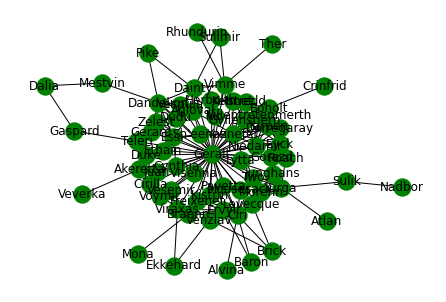

In [23]:
kamada_position = nx.kamada_kawai_layout(graph)

nx.draw(graph, with_labels=True, 
        node_color="green", edge_cmap=plt.cm.Greens, 
        pos=kamada_position)

plt.show()

Visualization Using Pyvis

In [24]:
from pyvis.network import Network

viz = Network(notebook=True, width="1000px", 
              height="800px", bgcolor="black", 
              font_color="yellow")

node_degree = dict(graph.degree) # visual hierarchy based on importance

nx.set_node_attributes(graph, node_degree, "size")

viz.from_nx(graph)

viz.show("relationship.html")

relationship.html


In social network analysis, there are different types of importance measurements, 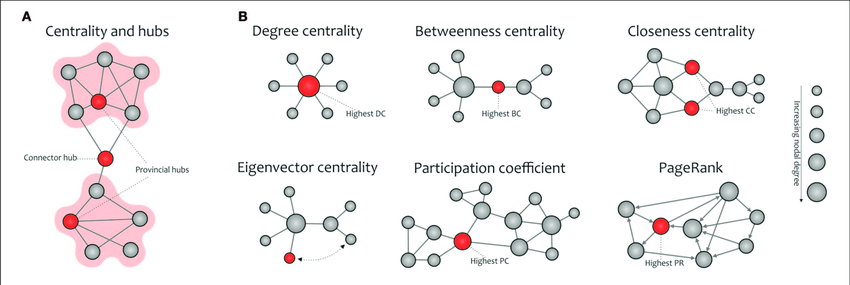

If you want to read more into this, https://www.researchgate.net/figure/Basic-concept-of-network-centralities-A-Hubs-connector-or-provincial-refer-to_fig3_333968671

Let's try Degree Centrality

<AxesSubplot:>

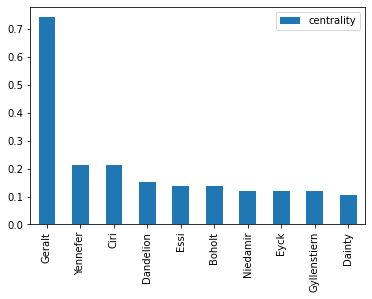

In [25]:
degrees = nx.degree_centrality(graph)

deg_df = pd.DataFrame.from_dict(degrees, orient="index", columns=["centrality"])
deg_df.sort_values("centrality", ascending=False).head(10).plot(kind="bar")

Lets try Closeness

<AxesSubplot:>

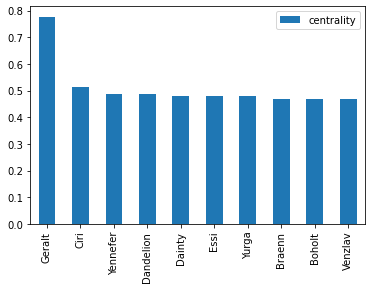

In [26]:
closenesses = nx.closeness_centrality(graph)

closeness_df = pd.DataFrame.from_dict(closenesses, orient="index", columns=["centrality"])
closeness_df.sort_values("centrality", ascending=False).head(10).plot(kind="bar")

Let's try Betweenness

<AxesSubplot:>

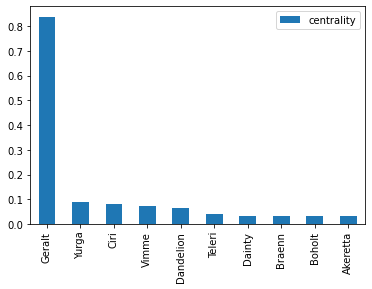

In [27]:
betweens = nx.betweenness_centrality(graph)

betweens_df = pd.DataFrame.from_dict(betweens, orient="index", columns=["centrality"])
betweens_df.sort_values("centrality", ascending=False).head(10).plot(kind="bar")

Louvain Community Detection

In [28]:
import community

communities = community.best_partition(graph)

nx.set_node_attributes(graph, communities, "group")

viz = Network(notebook=True, width="1000px", 
              height="800px", bgcolor="black", 
              font_color="yellow")

viz.from_nx(graph)

viz.show("relationship_communities.html")

relationship_communities.html


---------

But this is only for the first book, lets try to see the characters importance throughout the series

In [29]:
graph_of_books = []

book_files = [file for file in os.scandir("data") if ".txt" in file.name]
NER = spacy.load('en_core_web_sm')
book_files.sort(key=lambda x: x.name)

for book in book_files:
    
    NER = spacy.load('en_core_web_sm')
    book_read = open(book).read()
    book_content = NER(book_read)
    
    # Get Entities per Sentences List
    sent_entity_df = []
    for sent in book_content.sents:
        entity_list = [ent.text for ent in sent.ents]
        sent_entity_df.append({"sentence": sent, "entities": entity_list})

    sent_entity_df = pd.DataFrame(sent_entity_df)
    
    # Remove non-character entities
    sent_entity_df["character_entities"] = sent_entity_df["entities"].apply(lambda x: filter_ent(x, char_df))
    
    # Remove sentence that dont have entities
    sent_entity_df_clear = sent_entity_df[sent_entity_df["character_entities"].map(len) > 0]
    
    # only take first name
    sent_entity_df_clear["character_entities"] = sent_entity_df_clear["character_entities"].apply(lambda x: [item.split()[0] for item in x])
    
    # Create relationships
    window_size = 5
    relationships = []

    for i in range(sent_entity_df_clear.index[-1]): # last row index
        i_ = min(i + window_size, sent_entity_df_clear.index[-1]) # if i exceeds last index
        char_list = sum((sent_entity_df_clear.loc[i: i_]['character_entities']), [])

        char_unique = [char_list[i] for i in range(len(char_list)) if (i==0) or char_list[i] != char_list[i-1]]

        if len(char_unique) > 1:
            for idx, a in enumerate(char_unique[:-1]):
                b = char_unique[idx + 1]
                relationships.append({"source": a, "target": b})
                
    relationship_df = pd.DataFrame(relationships)
    
     # sort the values using np
    relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis=1), columns=relationship_df.columns)
    
    # groupby to sum all relationships
    relationship_df["value"] = 1
    relationship_df = relationship_df.groupby(["source", "target"], sort=False, as_index=False).sum() 
    
    graph = nx.from_pandas_edgelist(relationship_df, source="source", 
                                target="target", edge_attr="value", 
                                create_using=nx.Graph())
    
    # append result
    graph_of_books.append(graph)
    

C:\Users\LEGION~1\AppData\Local\Temp/ipykernel_12028/2585408787.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_clear["character_entities"] = sent_entity_df_clear["character_entities"].apply(lambda x: [item.split()[0] for item in x])


<AxesSubplot:>

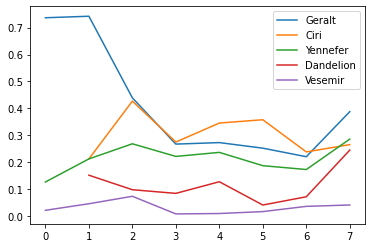

In [30]:
# All Books Centralities
centralities = [nx.degree_centrality(book) for book in graph_of_books]
centralities_df = pd.DataFrame.from_records(centralities)

# Centralities Plot Throughout the Books
centralities_df[["Geralt", "Ciri", "Yennefer", "Dandelion", "Vesemir"]].plot()

This graph shows the importance of 5 main characters throughout the series